Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [9]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [10]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [67]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [68]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    validation_split=.20
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    validation_split=.20
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

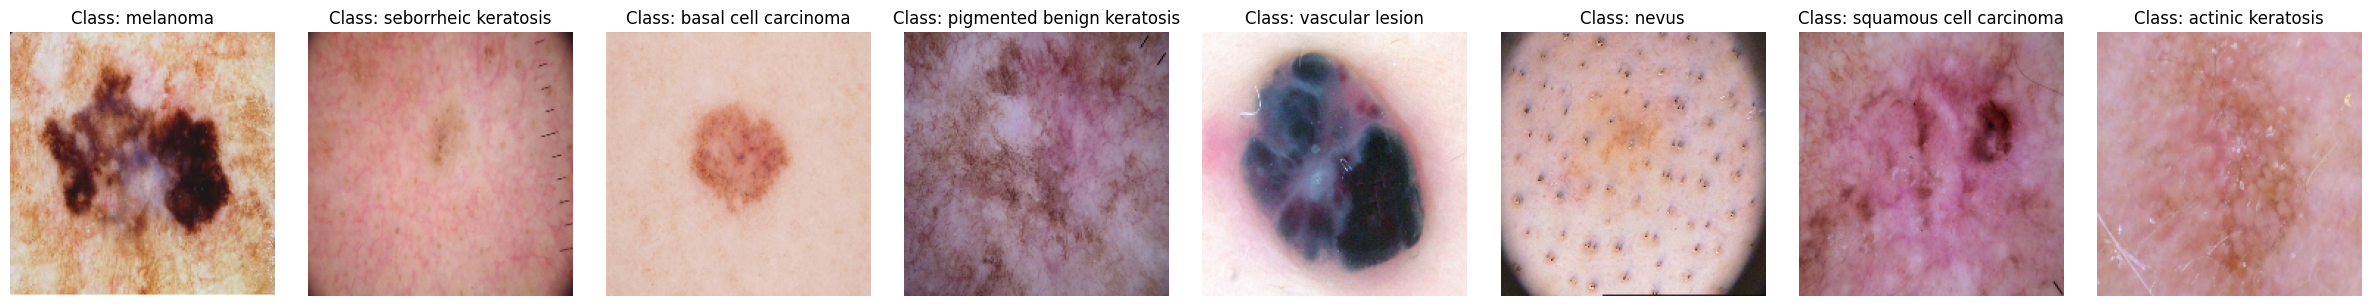

In [17]:
import matplotlib.pyplot as plt

class_images = {}

for images, labels in val_ds:
  image, label = images[0].numpy(), labels[0].numpy()
  if label not in class_images:
    class_images[label] = image

num_classes = len(class_images)
plt.figure(figsize=(num_classes * 3, 3))
for i, (label, image) in enumerate(class_images.items()):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Class: {class_names[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
len(class_images)

8

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
### Your code goes here
normalization_layer = layers.Rescaling(1./255)
normalized_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Build the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [21]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 189s 217ms/step - accuracy: 0.1803 - loss: 103.8945 - val_accuracy: 0.2528 - val_loss: 2.1191
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.2290 - loss: 2.1699 - val_accuracy: 0.2148 - val_loss: 2.1115
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2244 - loss: 2.0675 - val_accuracy: 0.2438 - val_loss: 2.0564
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2476 - loss: 2.3340 - val_accuracy: 0.2438 - val_loss: 2.0317
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2434 - loss: 1.9825 - val_accuracy: 0.2237 - val_loss: 2.0718
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2463 - loss: 1.9597 - val_accuracy: 0.2371 - val_loss: 2.0882
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2940 - loss: 1.8674 - val_accuracy: 0.2349 - val_loss: 2.0544
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2866 - loss: 1.8897 - val_accuracy: 0.23

### Visualizing training results

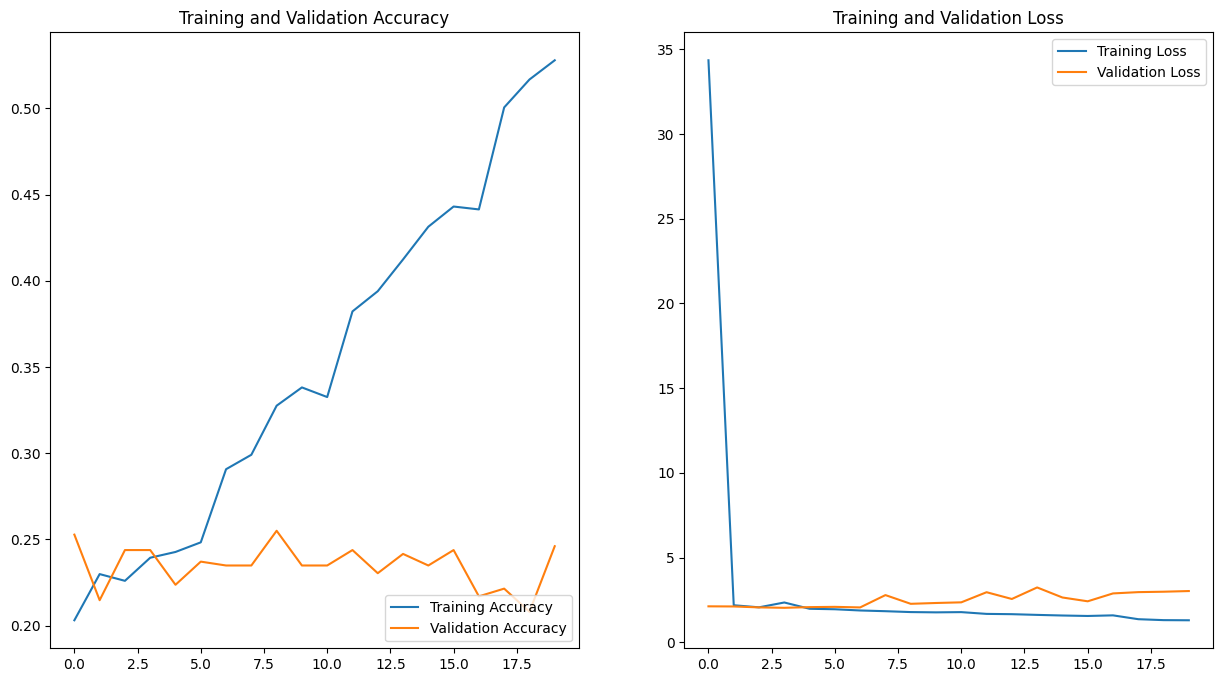

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- The model clearly shows the sign of overfiting to the training data

In [28]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
augmented_data = keras.Sequential([
                                      layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

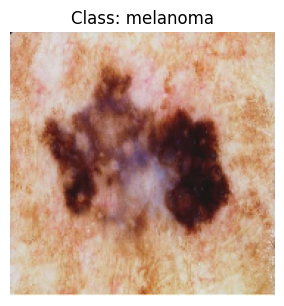

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for images, labels in val_ds:
  image, label = images[0].numpy(), labels[0].numpy()
  if label not in class_images:
    class_images[label] = augmented_data(image)
    break

num_classes = len(class_images)
plt.figure(figsize=(num_classes * 3, 3))
for i, (label, image) in enumerate(class_images.items()):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Class: {class_names[label]}')
    plt.axis('off')
    break

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

### Your code goes here
model = Sequential([
    augmented_data,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [32]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 324s 46ms/step - accuracy: 0.2286 - loss: 2.0514 - val_accuracy: 0.4139 - val_loss: 1.6814
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 43ms/step - accuracy: 0.4330 - loss: 1.6119 - val_accuracy: 0.4922 - val_loss: 1.4969
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4665 - loss: 1.4930 - val_accuracy: 0.5011 - val_loss: 1.4674
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5006 - loss: 1.4074 - val_accuracy: 0.5101 - val_loss: 1.5450
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5238 - loss: 1.3537 - val_accuracy: 0.4653 - val_loss: 1.5615
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4919 - loss: 1.4133 - val_accuracy: 0.5391 - val_loss: 1.4122
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5575 - loss: 1.2639 - val_accuracy: 0.5324 - val_loss: 1.3842
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5629 - loss: 1.2065 - val_accuracy: 0.5213 - val_loss:

### Visualizing the results

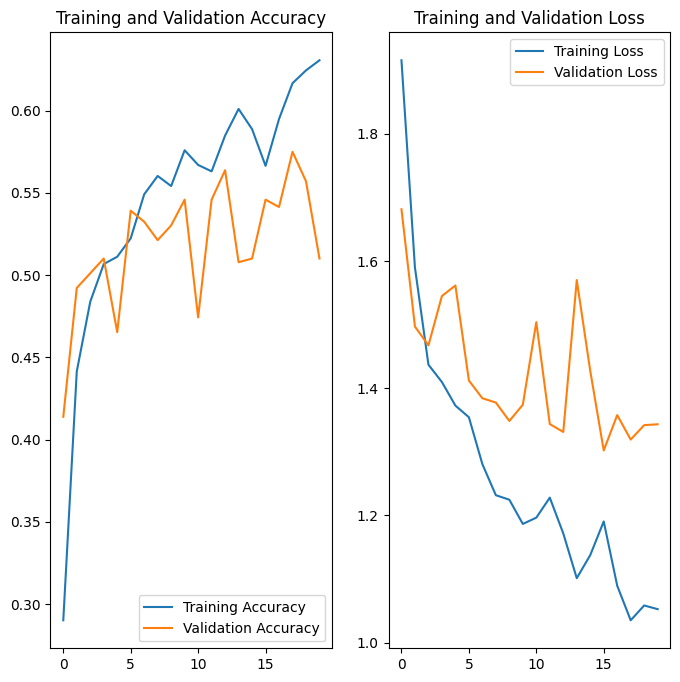

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- The training accuracy and validation accuracy variation has reduced now.
- Overfitting is resolved by using Data Augmentation technique

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

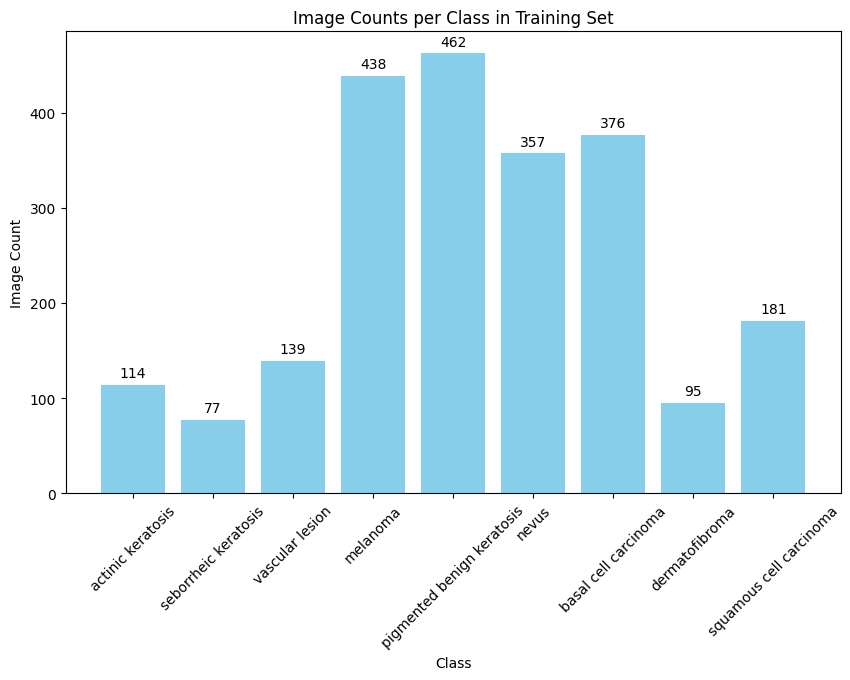

In [34]:
## Your code goes here.

train_class_counts = {subdir.name: len(list(subdir.glob('*.jpg')))
                      for subdir in data_dir_train.iterdir() if subdir.is_dir()}

plt.figure(figsize=(10, 6))
bars = plt.bar(train_class_counts.keys(), train_class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.title("Image Counts per Class in Training Set")
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()


#### **Todo:** Write your findings here:
There is a clear class imbalance
#### - Which class has the least number of samples?
  - seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
  - Melanoma, Nevus, Pigmented Benign Keratosis, Basal Cell Carcinoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset="/content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF3E8C06410>: 100%|██████████| 500/500 [00:22<00:00, 21.78 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CF2ADB0CDC0>: 100%|██████████| 500/500 [00:19<00:00, 26.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF33082DFC0>: 100%|██████████| 500/500 [00:26<00:00, 19.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF2BF978280>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7CF2ADB0E440>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF3E8C6AEC0>: 100%|██████████| 500/500 [00:22<00:00, 22.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF2AD1D4A60>: 100%|██████████| 500/500 [00:50<00:00,  9.90 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CF2ACB88970>: 100%|██████████| 500/500 [00:25<00:00, 19.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CF3308A6050>: 100%|██████████| 500/500 [00:21<00:00, 22.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [50]:

image_paths = []
labels = []

for label in os.listdir(data_dir_train):
    class_dir = os.path.join(data_dir_train, label)

    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            # Construct the full file path
            img_path = os.path.join(class_dir, filename)
            image_paths.append(img_path)
            labels.append(label)

original_df = pd.DataFrame({
    'image_path': image_paths,
    'Label': labels
})


In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [53]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,963
melanoma,939
basal cell carcinoma,877
nevus,858
squamous cell carcinoma,682
vascular lesion,640
actinic keratosis,615
dermatofibroma,596
seborrheic keratosis,578


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [54]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [56]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [59]:
## your code goes here

model = Sequential([
  augmented_data,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [61]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.1959 - loss: 7.0359 - val_accuracy: 0.0898 - val_loss: 83.7783
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step - accuracy: 0.2653 - loss: 1.9760 - val_accuracy: 0.1076 - val_loss: 47.0447
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 288ms/step - accuracy: 0.2790 - loss: 1.9173 - val_accuracy: 0.2205 - val_loss: 4.0795
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 287ms/step - accuracy: 0.3090 - loss: 1.8131 - val_accuracy: 0.3348 - val_loss: 2.0198
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 285ms/step - accuracy: 0.3583 - loss: 1.6862 - val_accuracy: 0.3920 - val_loss: 1.5845
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 267ms/step - accuracy: 0.3842 - loss: 1.5669 - val_accuracy: 0.3081 - val_loss: 2.1527
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.4032 - loss: 1.4963 - val_accuracy: 0.3281 - val_loss: 2.1839
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.4219 - loss: 1.4538 - v

#### **Todo:**  Visualize the model results

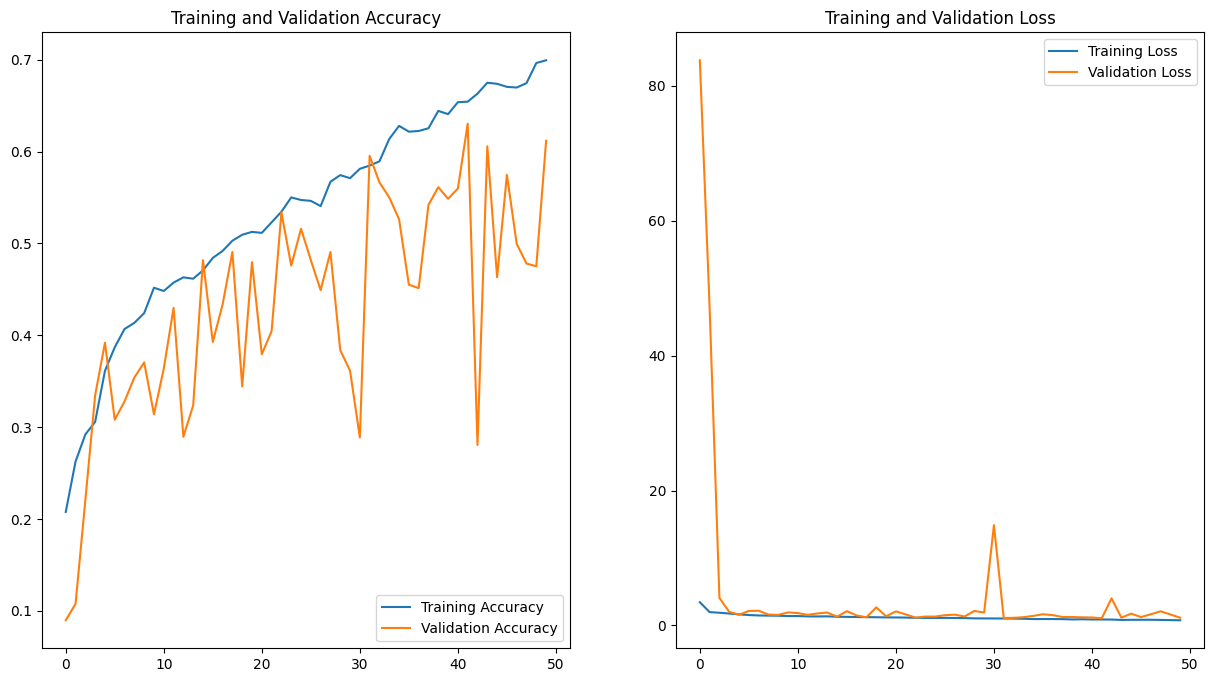

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Model has showns some improvement in terms of accuraccy and loss
- Rebalance has helped upto somepoint

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


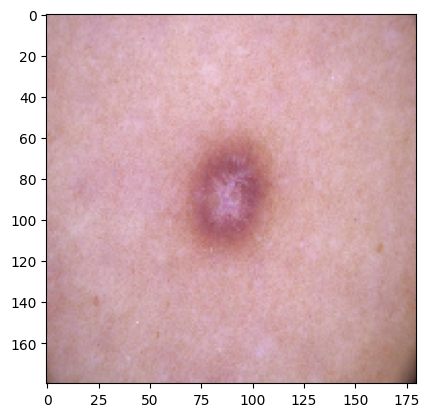

In [71]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path_test = os.path.join(data_dir_test, class_names[2], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180))
test_image = img_to_array(test_image)

plt.imshow(test_image.astype("uint8"))
plt.grid(False)

img = np.expand_dims(test_image, axis=0)

predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]

print("Actual Class: " + class_names[1] + '\n' + "Predicted Class: " + predicted_class)
